In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import text data from csv file
df=pd.read_csv('Text_data.csv')
df.head()

,Tweet,ADR_label
0,Intravenous azithromycin-induced ototoxicity.,1
1,"Immobilization, while Paget's bone disease was...",1
2,Unaccountable severe hypercalcemia in a patien...,1
3,METHODS: We report two cases of pseudoporphyri...,1
4,METHODS: We report two cases of pseudoporphyri...,1


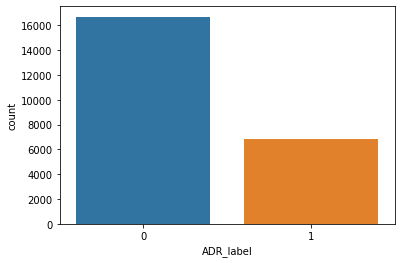

In [3]:
sns.countplot(df.ADR_label) #Imbalanced Target

In [4]:
import nltk
import string
import re
from nltk.stem.snowball import SnowballStemmer

In [5]:
stopwords=nltk.corpus.stopwords.words('english')
snowball_stemmer=SnowballStemmer(language='english')

In [6]:
def treat_text(text):
    edited_text=re.sub('\W'," ",text) #replace any sumbol with whitespace
    edited_text=re.sub("  "," ",edited_text) #replace double whitespace with single whitespace
    edited_text=edited_text.split(" ") #split the sentence into array of strings
    edited_text=" ".join([char for char in edited_text if char!= ""]) #remove any empty string from text
    edited_text=edited_text.lower() #lowercase
    edited_text=re.sub('\d+',"",edited_text) #Removing numerics
    edited_text=re.split('\W+',edited_text) #spliting based on whitespace or whitespaces
    edited_text=" ".join([snowball_stemmer.stem(word) for word in edited_text if word not in stopwords]) #Snowball Stemmer
    return edited_text

In [7]:
df['Treated_Tweet']=df.Tweet.apply(lambda x: treat_text(x))

In [8]:
df.head()

,Tweet,ADR_label,Treated_Tweet
0,Intravenous azithromycin-induced ototoxicity.,1,intraven azithromycin induc ototox
1,"Immobilization, while Paget's bone disease was...",1,immobil paget bone diseas present perhap enhan...
2,Unaccountable severe hypercalcemia in a patien...,1,unaccount sever hypercalcemia patient treat hy...
3,METHODS: We report two cases of pseudoporphyri...,1,method report two case pseudoporphyria caus na...
4,METHODS: We report two cases of pseudoporphyri...,1,method report two case pseudoporphyria caus na...


In [9]:
# Most Frequent words in the dataset
df.Treated_Tweet.str.split(expand=True).stack().value_counts()[:10]

patient      6700
case         3804
report       3155
treatment    2975
therapi      2485
develop      2276
year         1988
use          1745
associ       1665
induc        1614
dtype: int64

In [10]:
freq_words=df.Treated_Tweet.str.split(expand=True).stack().value_counts()[:10]
freq_words=list(freq_words.index)

In [11]:
# Rare words in the dataset appearing only once in the whole dataset
df.Treated_Tweet.str.split(expand=True).stack().value_counts()[-20:]

pcna              1
therapist         1
esi               1
iq                1
endstag           1
submiss           1
kabi              1
unsolv            1
subcorn           1
polyphaga         1
cerbral           1
muddi             1
keratos           1
esotropia         1
unsuppress        1
betalactam        1
pneumaturia       1
lifesci           1
postcraniotomi    1
xalatan           1
dtype: int64

In [12]:
rare_words=df.Treated_Tweet.str.split(expand=True).stack().value_counts()
rare_words=list(rare_words.loc[lambda x: x==1].index)

In [13]:
#Remove Frequent and Rare words
def remove_noise_words(text):
    edited_text=text.split()
    edited_text=[word for word in edited_text if word not in freq_words]
    edited_text=[word for word in edited_text if word not in rare_words]
    edited_text=" ".join(edited_text)
    return edited_text

In [14]:
df['Final_Treated_words']=df.Treated_Tweet.apply(lambda x: remove_noise_words(x))

In [15]:
df.head()

,Tweet,ADR_label,Treated_Tweet,Final_Treated_words
0,Intravenous azithromycin-induced ototoxicity.,1,intraven azithromycin induc ototox,intraven azithromycin ototox
1,"Immobilization, while Paget's bone disease was...",1,immobil paget bone diseas present perhap enhan...,immobil paget bone diseas present perhap enhan...
2,Unaccountable severe hypercalcemia in a patien...,1,unaccount sever hypercalcemia patient treat hy...,sever hypercalcemia treat hypoparathyroid dihy...
3,METHODS: We report two cases of pseudoporphyri...,1,method report two case pseudoporphyria caus na...,method two pseudoporphyria caus naproxen oxapr...
4,METHODS: We report two cases of pseudoporphyri...,1,method report two case pseudoporphyria caus na...,method two pseudoporphyria caus naproxen oxapr...


In [16]:
X=df.Final_Treated_words
y=df.ADR_label

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.20, random_state=10)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(18812,)
(4704,)
(18812,)
(4704,)


In [19]:
#Creating a list of Pipeline with well-known ML models
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB,ComplementNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

pipelines=[]
for model in [DecisionTreeClassifier(), MultinomialNB(), ComplementNB(), 
              LogisticRegression(solver='saga'), RidgeClassifier(solver='auto'), SVC(),RandomForestClassifier()]:
    pipeline=make_pipeline(TfidfVectorizer(), model)
    pipelines.append(pipeline)

In [20]:
#Training the model
import time
training_time=[]
for pipeline in pipelines:
    start=time.time()
    pipeline.fit(X_train, y_train)
    stop=time.time()
    training_time.append(stop-start)

In [21]:
#Prediction from test dataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
model_name=[]
precision_array=[]
recall_array=[]
f1_array=[]
test_time=[]
print("Classifiation Report\n")
print("*****************************************************")
for i, pipeline in enumerate(pipelines):
    start=time.time()
    y_pred=pipeline.predict(X_test)
    stop=time.time()
    test_time.append(stop-start)
    model_name.append(pipelines[i].steps[1][0].upper())
    f1_array.append(round(f1_score(y_test, y_pred, average='weighted'),2))
    precision_array.append(round(precision_score(y_test, y_pred, average='binary'),2))
    recall_array.append(round(recall_score(y_test, y_pred, average='binary'),2))
    print("\n",classification_report(y_test, y_pred))

Classifiation Report

*****************************************************

               precision    recall  f1-score   support

           0       0.88      0.86      0.87      3357
           1       0.67      0.71      0.69      1347

    accuracy                           0.81      4704
   macro avg       0.77      0.78      0.78      4704
weighted avg       0.82      0.81      0.82      4704


               precision    recall  f1-score   support

           0       0.84      0.96      0.90      3357
           1       0.85      0.54      0.66      1347

    accuracy                           0.84      4704
   macro avg       0.85      0.75      0.78      4704
weighted avg       0.84      0.84      0.83      4704


               precision    recall  f1-score   support

           0       0.92      0.81      0.86      3357
           1       0.64      0.83      0.72      1347

    accuracy                           0.82      4704
   macro avg       0.78      0.82      0.79   

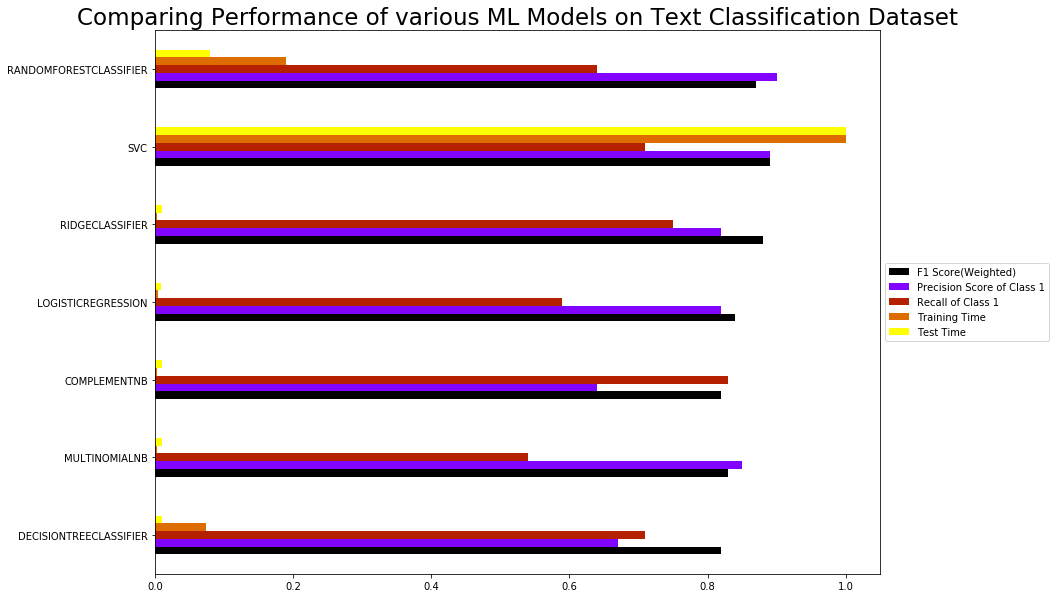

In [22]:
#Plotting the various performance metrix of all models
training_time=np.array(training_time)/np.max(training_time)
test_time=np.array(test_time)/np.max(test_time)
score_df=pd.DataFrame({'F1 Score(Weighted)':f1_array,
                     'Precision Score of Class 1':precision_array,
                     'Recall of Class 1':recall_array,
                      'Training Time': training_time,
                      'Test Time':test_time}, index=model_name)

f=plt.figure(figsize=(13,10))
plt.title('Comparing Performance of various ML Models on Text Classification Dataset', color='black',
         fontdict={'fontsize':23})
score_df.plot(kind='barh', ax=f.gca(), cmap='gnuplot')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()